Starting ARDNS-P simulation...
ARDNS-P Episode 0: Goals 0/1 (0.0%)
ARDNS-P Episode 500: Goals 280/501 (55.9%)
ARDNS-P Episode 1000: Goals 592/1001 (59.1%)
ARDNS-P Episode 1500: Goals 1046/1501 (69.7%)
ARDNS-P Episode 2000: Goals 1533/2001 (76.6%)
ARDNS-P Episode 2500: Goals 2007/2501 (80.2%)
ARDNS-P Episode 3000: Goals 2445/3001 (81.5%)
ARDNS-P Episode 3500: Goals 2919/3501 (83.4%)
ARDNS-P Episode 4000: Goals 3389/4001 (84.7%)
ARDNS-P Episode 4500: Goals 3832/4501 (85.1%)
ARDNS-P Episode 5000: Goals 4326/5001 (86.5%)
ARDNS-P Episode 5500: Goals 4775/5501 (86.8%)
ARDNS-P Episode 6000: Goals 5248/6001 (87.5%)
ARDNS-P Episode 6500: Goals 5710/6501 (87.8%)
ARDNS-P Episode 7000: Goals 6200/7001 (88.6%)
ARDNS-P Episode 7500: Goals 6694/7501 (89.2%)
ARDNS-P Episode 8000: Goals 7025/8001 (87.8%)
ARDNS-P Episode 8500: Goals 7488/8501 (88.1%)
ARDNS-P Episode 9000: Goals 7976/9001 (88.6%)
ARDNS-P Episode 9500: Goals 8452/9501 (89.0%)
ARDNS-P Episode 10000: Goals 8933/10001 (89.3%)
ARDNS-P Episode

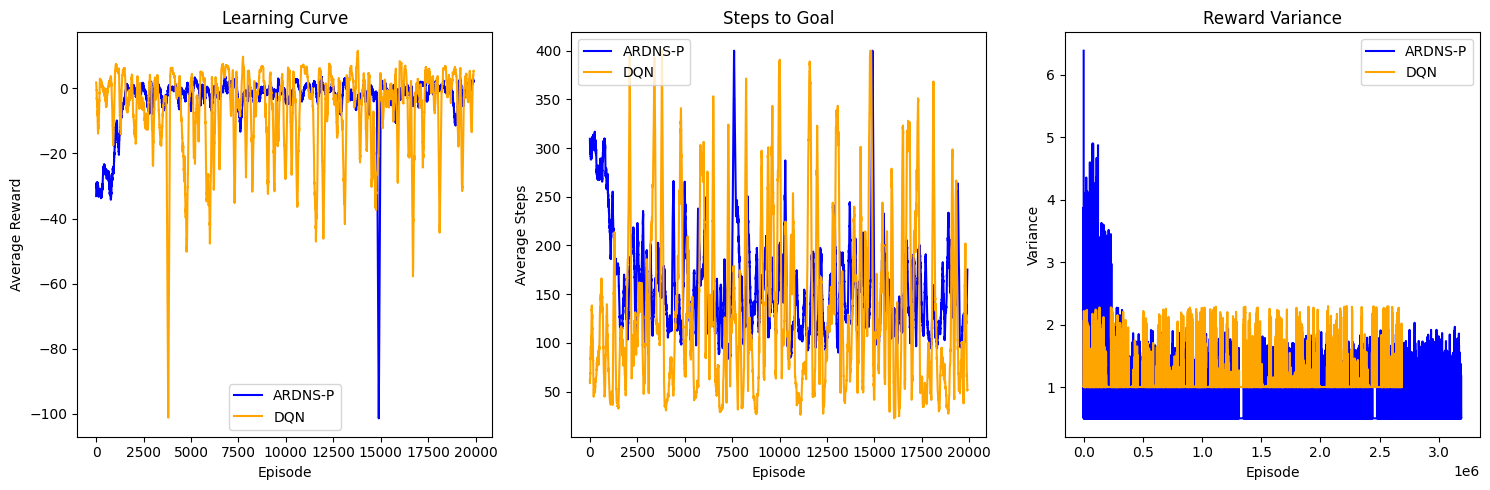

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class ARDNS_P:
    def __init__(self, state_dim=2, action_dim=4, ms_dim=10, ml_dim=20,
                 use_gmm=True, use_dual_memory=True, use_variability_plasticity=True,
                 use_piaget_stages=True, use_attention=True):
        # Architecture parameters
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.ms_dim = ms_dim  # Short-term memory dimension
        self.ml_dim = ml_dim  # Long-term memory dimension
        self.use_attention = use_attention

        # Memory systems
        self.W_s = np.random.randn(ms_dim, state_dim) * 0.1
        self.W_l = np.random.randn(ml_dim, state_dim) * 0.1
        self.W_a = np.random.randn(action_dim, ms_dim + ml_dim) * 0.1

        if use_attention:
            self.attention_weights = np.random.randn(ms_dim + ml_dim) * 0.1

        # Memory states
        self.M_s = np.zeros(ms_dim)
        self.M_l = np.zeros(ml_dim)
        self.memory_buffer = deque(maxlen=100)  # Experience replay buffer

        # Reward processing
        self.reward_memory = deque(maxlen=100)
        self.reward_stats = {'mean': 0, 'std': 1}

        # Learning parameters
        self.params = {
            'base_eta': 0.15,  # Base learning rate
            'eta_r': 0.05,     # Reward learning rate
            'alpha_s': 0.85,    # Short-term memory retention
            'alpha_l': 0.95,    # Long-term memory retention
            'beta': 0.1,        # Variance regulation
            'gamma': 0.01,      # State distance factor
            'tau': 1.5,         # Temperature parameter
            'epsilon': 1.0,     # Initial exploration rate
            'epsilon_min': 0.1, # Reverted to allow more exploration
            'epsilon_decay': 0.995,  # Exploration decay rate
            'clip_value': 5.0,   # Value clipping
            'sigma_min': 0.01,   # Minimum variance
            'curiosity_factor': 18.0  # Adjusted curiosity multiplier
        }

        # Developmental stages tracking
        self.episode = 0
        self.developmental_stages = {
            'sensorimotor': (0, 400),
            'preoperational': (401, 800),
            'concrete': (801, 1200),
            'formal': (1201, float('inf'))
        }

        # Performance tracking
        self.performance_history = []
        self.variance_history = []

        # Goal position for distance calculation in intrinsic reward
        self.goal = (9, 9)  # Assuming 10x10 grid, goal at (9, 9)

    def get_stage_parameters(self):
        """Get parameters adjusted for current developmental stage"""
        current_stage = None
        for stage, (start, end) in self.developmental_stages.items():
            if start <= self.episode <= end:
                current_stage = stage
                break

        if current_stage == 'sensorimotor':
            return {
                'eta': self.params['base_eta'] * 2.0,
                'epsilon': max(0.9, self.params['epsilon'] * (self.params['epsilon_decay'] ** self.episode)),
                'alpha_s': 0.7,
                'alpha_l': 0.8,
                'curiosity_bonus': 8.0,
                'exploration_boost': 2.0
            }
        elif current_stage == 'preoperational':
            return {
                'eta': self.params['base_eta'] * 1.5,
                'epsilon': max(0.6, self.params['epsilon'] * (self.params['epsilon_decay'] ** (self.episode - 400))),
                'alpha_s': 0.8,
                'alpha_l': 0.9,
                'curiosity_bonus': 6.0,
                'exploration_boost': 1.5
            }
        elif current_stage == 'concrete':
            return {
                'eta': self.params['base_eta'] * 1.2,
                'epsilon': max(0.3, self.params['epsilon'] * (self.params['epsilon_decay'] ** (self.episode - 800))),
                'alpha_s': 0.85,
                'alpha_l': 0.95,
                'curiosity_bonus': 3.0,
                'exploration_boost': 1.0
            }
        else:  # Formal operational stage
            return {
                'eta': self.params['base_eta'],
                'epsilon': max(self.params['epsilon_min'],
                             self.params['epsilon'] * (self.params['epsilon_decay'] ** (self.episode - 1200))),
                'alpha_s': 0.9,
                'alpha_l': 0.98,
                'curiosity_bonus': 1.0,
                'exploration_boost': 0.5
            }

    def compute_attention(self, state):
        """Compute attention weights for memory integration"""
        if not self.use_attention:
            return np.concatenate([self.M_s, self.M_l])

        # Compute attention scores
        short_term_attention = np.tanh(self.W_s @ state)
        long_term_attention = sigmoid(self.W_l @ state)

        # Combine with memory states
        attended_short = short_term_attention * self.M_s
        attended_long = long_term_attention * self.M_l

        return np.concatenate([attended_short, attended_long])

    def update_memory(self, state):
        """Update both short-term and long-term memory systems"""
        stage_params = self.get_stage_parameters()

        # Update short-term memory with faster adaptation
        self.M_s = (stage_params['alpha_s'] * self.M_s +
                   (1 - stage_params['alpha_s']) * np.tanh(self.W_s @ state))

        # Update long-term memory with slower adaptation
        self.M_l = (stage_params['alpha_l'] * self.M_l +
                   (1 - stage_params['alpha_l']) * np.tanh(self.W_l @ state))

        # Store experience in memory buffer
        self.memory_buffer.append((state.copy(), self.M_s.copy(), self.M_l.copy()))

    def update_reward_stats(self, reward):
        """Update running statistics of rewards"""
        self.reward_memory.append(reward)
        if len(self.reward_memory) > 1:
            self.reward_stats['mean'] = np.mean(self.reward_memory)
            self.reward_stats['std'] = max(np.std(self.reward_memory) + 1e-6, 0.5)

    def compute_intrinsic_reward(self, state):
        """Compute curiosity-driven intrinsic reward with distance component"""
        novelty = 1.0 / (1.0 + np.exp(-np.linalg.norm(state)))
        goal_x, goal_y = self.goal
        state_x, state_y = state
        distance = abs(goal_x - state_x) + abs(goal_y - state_y)
        distance_factor = 10.0 / (1.0 + distance)  # Adjusted weight for states closer to goal
        return self.params['curiosity_factor'] * novelty * distance_factor

    def update_weights(self, state, action, reward, next_state, curiosity_bonus=0):
        """Update model weights using adaptive learning"""
        stage_params = self.get_stage_parameters()

        total_reward = reward + curiosity_bonus
        self.update_reward_stats(total_reward)

        normalized_reward = (total_reward - self.reward_stats['mean']) / self.reward_stats['std']

        prev_memory = self.compute_attention(state)
        next_memory = self.compute_attention(next_state)

        current_value = self.W_a[action] @ prev_memory
        next_value = np.max(self.W_a @ next_memory)
        td_error = normalized_reward + 0.9 * next_value - current_value

        state_diff = np.linalg.norm(next_state - state)
        adaptive_eta = (stage_params['eta'] * np.exp(-self.params['gamma'] * state_diff) /
                      (1 + self.params['beta'] * self.reward_stats['std']))

        self.W_a[action] += adaptive_eta * td_error * prev_memory
        self.W_a = np.clip(self.W_a, -self.params['clip_value'], self.params['clip_value'])

        memory_grad = np.outer(self.W_a[action], state)
        self.W_s += adaptive_eta * 0.7 * memory_grad[:self.ms_dim]
        self.W_l += adaptive_eta * 0.3 * memory_grad[self.ms_dim:]

        self.W_s = np.clip(self.W_s, -self.params['clip_value'], self.params['clip_value'])
        self.W_l = np.clip(self.W_l, -self.params['clip_value'], self.params['clip_value'])

        self.performance_history.append(total_reward)
        self.variance_history.append(self.reward_stats['std'])

    def choose_action(self, state, visited_states):
        """Select action using an epsilon-greedy policy with curiosity"""
        stage_params = self.get_stage_parameters()
        self.update_memory(state)

        memory = self.compute_attention(state)
        action_values = self.W_a @ memory

        if tuple(state) not in visited_states:
            curiosity_bonus = self.compute_intrinsic_reward(state) * stage_params['curiosity_bonus']
        else:
            curiosity_bonus = 0

        if np.random.rand() < stage_params['epsilon']:
            action = np.random.randint(self.action_dim)
        else:
            action = np.argmax(action_values)

        return action, curiosity_bonus

class DQN:
    def __init__(self, state_dim=2, action_dim=4, hidden_dim=32):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim

        # Q-network weights (simple two-layer network)
        self.W1 = np.random.randn(state_dim, hidden_dim) * 0.1
        self.W2 = np.random.randn(hidden_dim, action_dim) * 0.1

        # Target network weights
        self.target_W1 = self.W1.copy()
        self.target_W2 = self.W2.copy()

        # Experience replay buffer
        self.memory = deque(maxlen=1000)

        # Reward processing for variance tracking
        self.reward_memory = deque(maxlen=100)
        self.reward_stats = {'mean': 0, 'std': 1}

        # Learning parameters
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.985
        self.learning_rate = 0.0005  # Reduced to improve stability
        self.gamma = 0.9  # Discount factor
        self.target_update_freq = 1000
        self.clip_value = 5.0  # Weight clipping value
        self.curiosity_factor = 8.0  # Adjusted for balanced exploration

        # Performance tracking
        self.performance_history = []
        self.variance_history = []
        self.step_count = 0

        # Goal position for curiosity
        self.goal = (9, 9)  # Assuming 10x10 grid, goal at (9, 9)

    def update_reward_stats(self, reward):
        """Update running statistics of rewards"""
        self.reward_memory.append(reward)
        if len(self.reward_memory) > 1:
            self.reward_stats['mean'] = np.mean(self.reward_memory)
            self.reward_stats['std'] = max(np.std(self.reward_memory) + 1e-6, 1.0)

    def compute_intrinsic_reward(self, state):
        """Compute a simple curiosity-driven intrinsic reward"""
        novelty = 1.0 / (1.0 + np.exp(-np.linalg.norm(state)))
        goal_x, goal_y = self.goal
        state_x, state_y = state
        distance = abs(goal_x - state_x) + abs(goal_y - state_y)
        distance_factor = 5.0 / (1.0 + distance)
        return self.curiosity_factor * novelty * distance_factor

    def forward(self, state, weights_W1, weights_W2):
        """Forward pass through the Q-network"""
        hidden = np.tanh(state @ weights_W1)
        q_values = hidden @ weights_W2
        return q_values

    def choose_action(self, state, visited_states=None):
        """Select action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            q_values = self.forward(state, self.W1, self.W2)
            action = np.argmax(q_values)

        # Compute curiosity bonus
        if visited_states is not None and tuple(state) not in visited_states:
            curiosity_bonus = self.compute_intrinsic_reward(state)
        else:
            curiosity_bonus = 0

        return action, curiosity_bonus

    def update_weights(self, state, action, reward, next_state, curiosity_bonus=0):
        """Update Q-network weights using DQN update rule"""
        self.step_count += 1
        total_reward = reward + curiosity_bonus
        self.memory.append((state.copy(), action, total_reward, next_state.copy()))
        self.update_reward_stats(total_reward)

        # Sample a batch from memory
        if len(self.memory) < 64:
            return

        batch = random.sample(self.memory, 64)
        states = np.array([t[0] for t in batch])
        actions = np.array([t[1] for t in batch])
        rewards = np.array([t[2] for t in batch])
        next_states = np.array([t[3] for t in batch])

        # Compute Q-values
        hidden = np.tanh(states @ self.W1)
        q_values = hidden @ self.W2
        q_next = self.forward(next_states, self.target_W1, self.target_W2)

        # Compute target Q-values
        targets = q_values.copy()
        for i in range(len(batch)):
            targets[i, actions[i]] = rewards[i] + self.gamma * np.max(q_next[i])

        # Gradient descent
        hidden = np.tanh(states @ self.W1)
        q_values = hidden @ self.W2
        error = targets - q_values

        # Gradient clipping
        error = np.clip(error, -1.0, 1.0)

        # Update W2
        grad_W2 = hidden.T @ error
        grad_W2 = np.clip(grad_W2, -1.0, 1.0)
        self.W2 += self.learning_rate * grad_W2

        # Update W1
        grad_hidden = (error @ self.W2.T) * (1 - np.tanh(states @ self.W1)**2)
        grad_hidden = np.clip(grad_hidden, -1.0, 1.0)
        grad_W1 = states.T @ grad_hidden
        grad_W1 = np.clip(grad_W1, -1.0, 1.0)
        self.W1 += self.learning_rate * grad_W1

        # Clip weights to prevent explosion
        self.W1 = np.clip(self.W1, -self.clip_value, self.clip_value)
        self.W2 = np.clip(self.W2, -self.clip_value, self.clip_value)

        # Update target network
        if self.step_count % self.target_update_freq == 0:
            self.target_W1 = self.W1.copy()
            self.target_W2 = self.W2.copy()

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Store performance metrics
        self.performance_history.append(total_reward)
        self.variance_history.append(self.reward_stats['std'])

class GridWorld:
    def __init__(self, size=10):
        self.size = size
        self.goal = (size-1, size-1)
        self.obstacles = set()
        self.reset()
        self.update_obstacles()

    def reset(self):
        self.state = (0, 0)
        self.visited_states = set()
        return np.array(self.state, dtype=np.float32)

    def step(self, action):
        x, y = self.state

        # Action mapping
        if action == 0: y = min(y+1, self.size-1)  # Up
        elif action == 1: y = max(y-1, 0)          # Down
        elif action == 2: x = max(x-1, 0)          # Left
        elif action == 3: x = min(x+1, self.size-1) # Right

        next_state = (x, y)

        if next_state in self.obstacles:
            next_state = self.state

        self.state = next_state
        self.visited_states.add(tuple(next_state))

        goal_x, goal_y = self.goal
        distance = abs(goal_x - x) + abs(goal_y - y)

        if next_state == self.goal:
            reward = 10.0
        elif next_state in self.obstacles:
            reward = -3.0
        else:
            progress = (x + y) / (2 * (self.size-1))
            reward = -0.002 + 0.08 * progress - 0.015 * distance  # Adjusted penalties and rewards

        done = next_state == self.goal
        return np.array(next_state, dtype=np.float32), reward, done

    def update_obstacles(self):
        self.obstacles = set()
        num_obstacles = int(self.size * self.size * 0.05)

        for _ in range(num_obstacles):
            while True:
                x = np.random.randint(0, self.size)
                y = np.random.randint(0, self.size)
                pos = (x, y)
                if pos != (0, 0) and pos != self.goal:
                    self.obstacles.add(pos)
                    break

def run_simulation(model, env, model_name, episodes=20000, max_steps=400):
    rewards = []
    steps_to_goal = []
    goals_reached = 0

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False

        if episode % 100 == 0:
            env.update_obstacles()

        if hasattr(model, 'episode'):
            model.episode = episode

        while not done and steps < max_steps:
            prev_state = state.copy()
            action, curiosity_bonus = model.choose_action(state, env.visited_states)
            next_state, reward, done = env.step(action)

            model.update_weights(state, action, reward, prev_state, curiosity_bonus)

            state = next_state
            total_reward += reward
            steps += 1

        rewards.append(total_reward)
        steps_to_goal.append(steps if done else max_steps)
        if done:
            goals_reached += 1

        if episode % 500 == 0:
            print(f"{model_name} Episode {episode}: Goals {goals_reached}/{episode+1} ({goals_reached/(episode+1)*100:.1f}%)")

    return rewards, steps_to_goal, goals_reached

# Main execution
if __name__ == "__main__":
    np.random.seed(42)

    # Initialize environment
    env = GridWorld(size=10)

    # Initialize models
    ardns_model = ARDNS_P(state_dim=2, action_dim=4, ms_dim=10, ml_dim=20,
                         use_attention=True, use_piaget_stages=True)
    dqn_model = DQN(state_dim=2, action_dim=4, hidden_dim=32)

    # Run simulations
    print("Starting ARDNS-P simulation...")
    ardns_rewards, ardns_steps, ardns_goals = run_simulation(ardns_model, env, "ARDNS-P", episodes=20000)

    # Reset environment for DQN
    np.random.seed(42)  # Reset seed for consistency
    env = GridWorld(size=10)
    print("\nStarting DQN simulation...")
    dqn_rewards, dqn_steps, dqn_goals = run_simulation(dqn_model, env, "DQN", episodes=20000)

    # Print results for ARDNS-P
    print("\nARDNS-P Final Results:")
    print(f"Goals reached: {ardns_goals}/20000 ({ardns_goals/20000*100:.1f}%)")
    print(f"Mean reward (all episodes): {np.mean(ardns_rewards):.4f} ± {np.std(ardns_rewards):.4f}")
    print(f"Mean steps to goal (all episodes): {np.mean(ardns_steps):.1f} ± {np.std(ardns_steps):.1f}")
    print("\nMetrics for Last 200 Episodes:")
    print(f"Mean Reward (last 200): {np.mean(ardns_rewards[-200:]):.4f} ± {np.std(ardns_rewards[-200:]):.4f}")
    ardns_successful_steps = [s for s in ardns_steps[-200:] if s < 400]
    print(f"Steps to Goal (last 200, successful episodes): {np.mean(ardns_successful_steps):.1f} ± {np.std(ardns_successful_steps):.1f}" if ardns_successful_steps else "No successful episodes")

    # Print results for DQN
    print("\nDQN Final Results:")
    print(f"Goals reached: {dqn_goals}/20000 ({dqn_goals/20000*100:.1f}%)")
    print(f"Mean reward (all episodes): {np.mean(dqn_rewards):.4f} ± {np.std(dqn_rewards):.4f}")
    print(f"Mean steps to goal (all episodes): {np.mean(dqn_steps):.1f} ± {np.std(dqn_steps):.1f}")
    print("\nMetrics for Last 200 Episodes:")
    print(f"Mean Reward (last 200): {np.mean(dqn_rewards[-200:]):.4f} ± {np.std(dqn_rewards[-200:]):.4f}")
    dqn_successful_steps = [s for s in dqn_steps[-200:] if s < 400]
    print(f"Steps to Goal (last 200, successful episodes): {np.mean(dqn_successful_steps):.1f} ± {np.std(dqn_successful_steps):.1f}" if dqn_successful_steps else "No successful episodes")

    # Plot results
    plt.figure(figsize=(15, 5))

    # Learning curve
    plt.subplot(1, 3, 1)
    plt.plot(np.convolve(ardns_rewards, np.ones(100)/100, mode='valid'), label='ARDNS-P', color='blue')
    plt.plot(np.convolve(dqn_rewards, np.ones(100)/100, mode='valid'), label='DQN', color='orange')
    plt.title("Learning Curve")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend()

    # Steps to goal
    plt.subplot(1, 3, 2)
    plt.plot(np.convolve(ardns_steps, np.ones(100)/100, mode='valid'), label='ARDNS-P', color='blue')
    plt.plot(np.convolve(dqn_steps, np.ones(100)/100, mode='valid'), label='DQN', color='orange')
    plt.title("Steps to Goal")
    plt.xlabel("Episode")
    plt.ylabel("Average Steps")
    plt.legend()

    # Variance tracking
    plt.subplot(1, 3, 3)
    plt.plot(np.convolve(ardns_model.variance_history, np.ones(100)/100, mode='valid'), label='ARDNS-P', color='blue')
    plt.plot(np.convolve(dqn_model.variance_history, np.ones(100)/100, mode='valid'), label='DQN', color='orange')
    plt.title("Reward Variance")
    plt.xlabel("Episode")
    plt.ylabel("Variance")
    plt.legend()

    plt.tight_layout()
    plt.show()